In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


#### 1. 데이터 로드 및 전처리

📌 주식 데이터와 시장 지수 데이터 로드 


In [28]:
# 파일 경로 설정
file_paths = {
    # 주식 
    "SM": "041510 과거 데이터.csv",
    # 시장
    "코스닥": "코스닥 과거 데이터.csv",
}

# 데이터 로드
dataframes = {ticker: pd.read_csv(path) for ticker, path in file_paths.items()}

# 날짜 형식 변환
for ticker, df in dataframes.items():
    df["날짜"] = pd.to_datetime(df["날짜"].str.replace(" ", ""), errors='coerce')  # 공백 제거 후 변환
    df.set_index("날짜", inplace=True)
    df.sort_index(inplace=True)  # 날짜 기준 정렬

In [31]:
# 원하는 데이터 선택 (예: "RUN" 데이터)
selected_ticker = "SM"  # 원하는 데이터 선택
file_path = file_paths[selected_ticker]

# CSV 파일 로드
df = pd.read_csv(file_path)
df


,날짜,종가,시가,고가,저가,거래량,변동 %
0,2014- 03- 14,"51,700","52,100","53,200","51,700",214.32K,-2.82%
1,2014- 03- 17,"50,000","51,500","51,600","48,550",517.68K,-3.29%
2,2014- 03- 18,"51,000","50,100","51,100","49,250",249.08K,2.00%
3,2014- 03- 19,"49,750","51,000","51,300","49,650",199.28K,-2.45%
4,2014- 03- 20,"47,800","46,550","49,050","45,800",1.49M,-3.92%
...,...,...,...,...,...,...,...
2969,2025- 03- 21,"100,300","96,700","100,600","95,900",166.22K,5.58%
2970,2025- 03- 24,"102,700","99,900","104,200","99,800",152.90K,2.39%
2971,2025- 03- 25,"103,900","102,700","105,500","100,300",171.47K,1.17%
2972,2025- 03- 26,"105,000","104,700","105,500","101,600",99.80K,1.06%


In [32]:
# 원하는 데이터 선택 (예: "RUN" 데이터)
selected_ticker = "코스닥"  # 원하는 데이터 선택
file_path = file_paths[selected_ticker]

# CSV 파일 로드
df = pd.read_csv(file_path)
df


,날짜,종가,시가,고가,저가,거래량,변동 %
0,2014- 01- 02,496.28,502.41,502.87,496.06,264.27K,-0.74%
1,2014- 01- 03,499.33,496.67,499.33,493.79,295.10K,0.61%
2,2014- 01- 06,500.62,500.86,501.29,498.73,288.71K,0.26%
3,2014- 01- 07,504.86,500.42,505.02,500.42,332.45K,0.85%
4,2014- 01- 08,509.78,507.55,510.60,506.41,368.75K,0.97%
...,...,...,...,...,...,...,...
2755,2025- 03- 21,719.41,724.94,727.15,713.82,735.72M,-0.79%
2756,2025- 03- 24,720.22,721.39,725.34,718.67,678.08M,0.11%
2757,2025- 03- 25,711.26,725.34,725.84,709.67,729.73M,-1.24%
2758,2025- 03- 26,716.48,714.36,717.30,705.38,706.70M,0.73%


#### 2. 로그 수익률 계산
📌 정상 수익률 및 비정상 수익률 계산을 위한 로그 수익률 추가

In [33]:
for ticker, df in dataframes.items():
    # 쉼표 제거 + 숫자형 변환
    df["종가"] = df["종가"].astype(str).str.replace(",", "").astype(float)
    df["로그 수익률"] = np.log(df["종가"] / df["종가"].shift(1))

In [34]:
print(dataframes["SM"]["로그 수익률"].isna().sum())
print(dataframes["코스닥"]["로그 수익률"].isna().sum())


1
1


#### 3. 이벤트 설정
📌 선택한 모든 이벤트를 사용


In [ ]:
from datetime import datetime

# 이벤트 리스트 (스캔들 날짜)
event_dates = ['2014.06.19', '2014.04.04', '2015.04.20', '2014.01.03', '2014.01.01',
               '2020.01.13', '2020.10.29', '2016.04.01', '2019.01.01', '2021.08.23']

# 날짜 형식 수정: YYYY.MM.DD → datetime 객체
event_dates = [datetime.strptime(date, "%Y.%m.%d") for date in event_dates]

# 필요 시 이벤트 간 최소 30일 간격 필터링 (비활성화 상태)
adjusted_events = event_dates
len(adjusted_events)


10

#### 4. 정상 수익률(Estimation Window) 계산

📌 시장조정수익률 사용

시장 전체를 대표하는 지수(S&P 500)을 정상 수익률로 놓고 AR과 CAR을 계산하는 방법


📌 각 이벤트 발생일을 기준으로 -120일 ~ -10일 데이터를 이용해 정상 수익률 예측

​


In [41]:
def estimate_normal_return(market_df, event_date):
    """ 시장조정수익률 방식으로 정상 수익률 계산 """
    estimation_start = event_date - timedelta(days=120)
    estimation_end = event_date - timedelta(days=10)

    market_window = market_df.loc[estimation_start:estimation_end]
    
    # 사건 이전 시장수익률 평균을 정상수익률로 사용
    normal_return = market_window["로그 수익률"].mean()
    
    return normal_return

####  5. 비정상 수익률(AR) 및 누적 비정상 수익률(CAR) 계산

In [42]:
def calculate_abnormal_return(df, market_df, event_date):
    """ 시장조정수익률 방식으로 비정상 수익률 및 누적 비정상 수익률 계산 """
    event_window_start = event_date - timedelta(days=3)
    event_window_end = event_date + timedelta(days=10)

    event_window = df.loc[event_window_start:event_window_end]
    market_window = market_df.loc[event_window_start:event_window_end]

    # 시장조정수익률 방법: 정상수익률 = 시장수익률
    expected_return = market_window["로그 수익률"]
    abnormal_return = event_window["로그 수익률"] - expected_return

    return abnormal_return, abnormal_return.cumsum()

#### 6. 단계별 시각화

In [43]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def set_korean_font():
    """ 한글 폰트 설정 (윈도우, 맥, 리눅스 대응) """
    import platform
    system_name = platform.system()

    if system_name == "Windows":
        plt.rc("font", family="Malgun Gothic")  # Windows: 맑은 고딕
    elif system_name == "Darwin":  # macOS
        plt.rc("font", family="AppleGothic")
    else:  # Linux
        plt.rc("font", family="NanumGothic")

    # 마이너스 기호 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

# 한글 폰트 적용
set_korean_font()


In [ ]:
def plot_event_study(df, market_df, event_date, ticker):
    """ 이벤트 스터디 결과 시각화 (한 행에 AR, CAR 출력) """
    set_korean_font()  # 한글 폰트 적용

    normal_return = estimate_normal_return(market_df, event_date)
    ar, car = calculate_abnormal_return(df, market_df, event_date)

    # 1행 2열 그래프 생성
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 📌 AR 그래프
    axes[0].plot(ar.index, ar, label="비정상 수익률 (AR)", marker="o", linestyle="-")
    axes[0].axvline(event_date, color="red", linestyle="--", label="이벤트 발생일")
    axes[0].set_title(f"{ticker} 이벤트 스터디 ({event_date.strftime('%Y-%m-%d')})")
    axes[0].set_xlabel("날짜")
    axes[0].set_ylabel("비정상 수익률")
    axes[0].legend()
    axes[0].grid()

    # 📌 CAR 그래프
    axes[1].plot(car.index, car, label="누적 비정상 수익률 (CAR)", marker="o", linestyle="-", color="green")
    axes[1].axvline(event_date, color="red", linestyle="--", label="이벤트 발생일")
    axes[1].set_title(f"{ticker} 누적 비정상 수익률 (CAR) ({event_date.strftime('%Y-%m-%d')})")
    axes[1].set_xlabel("날짜")
    axes[1].set_ylabel("누적 비정상 수익률")
    axes[1].legend()
    axes[1].grid()

    # 그래프 정렬
    plt.tight_layout()
    plt.show()

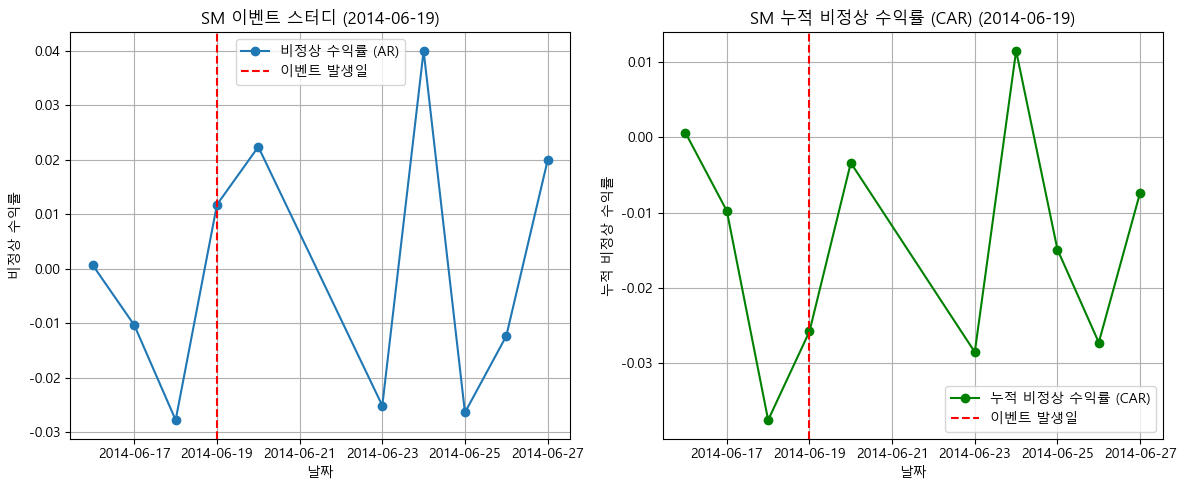

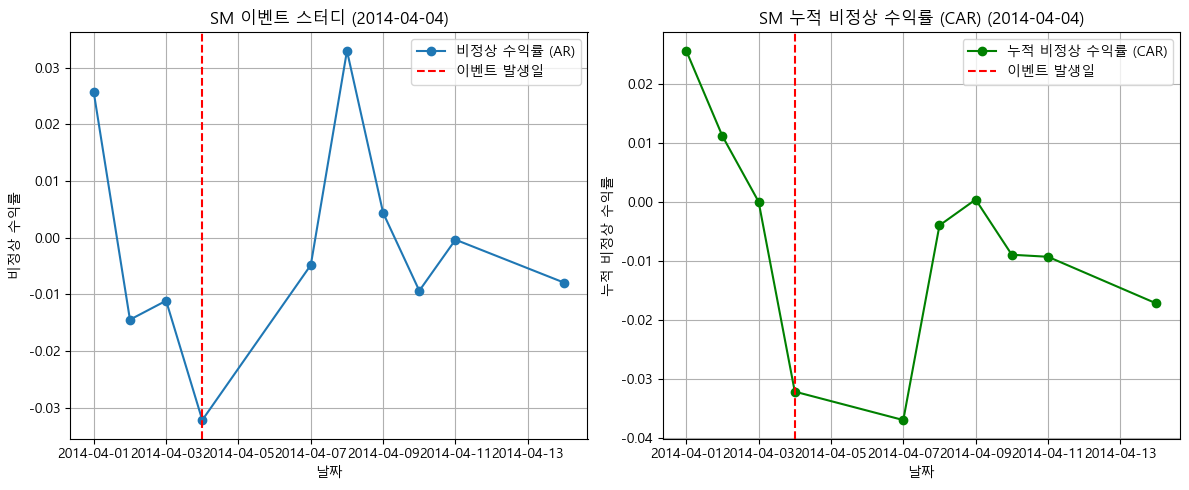

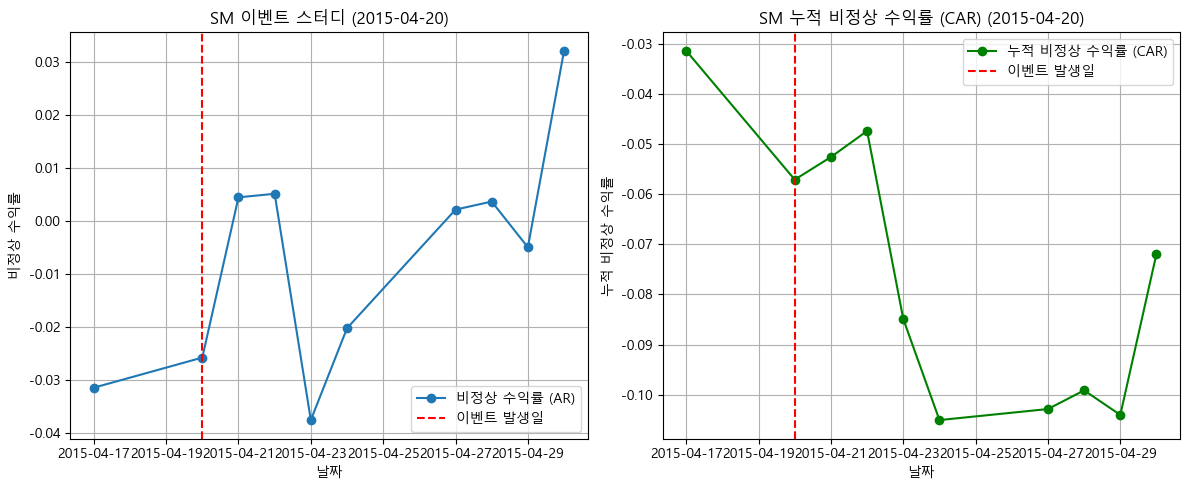

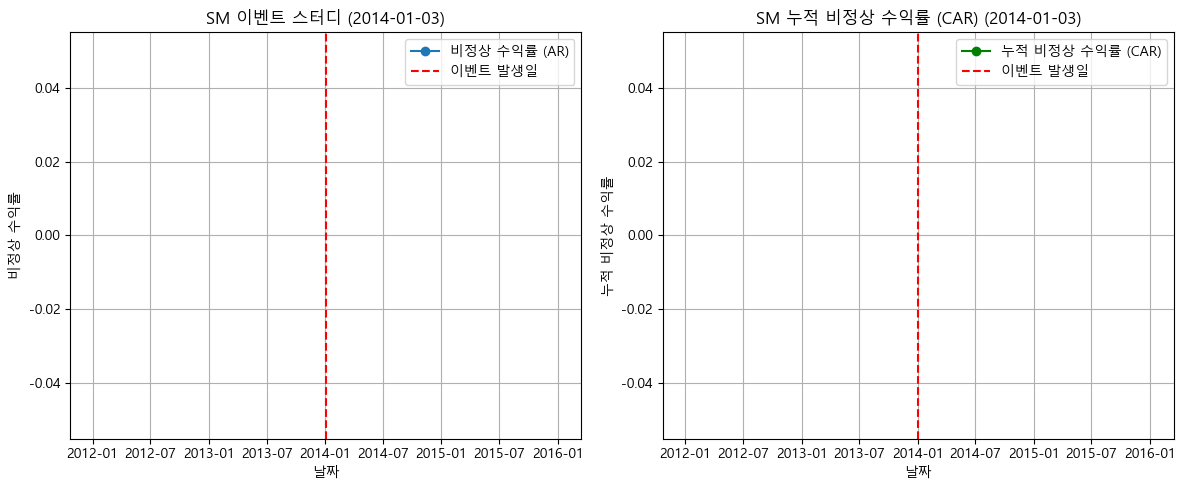

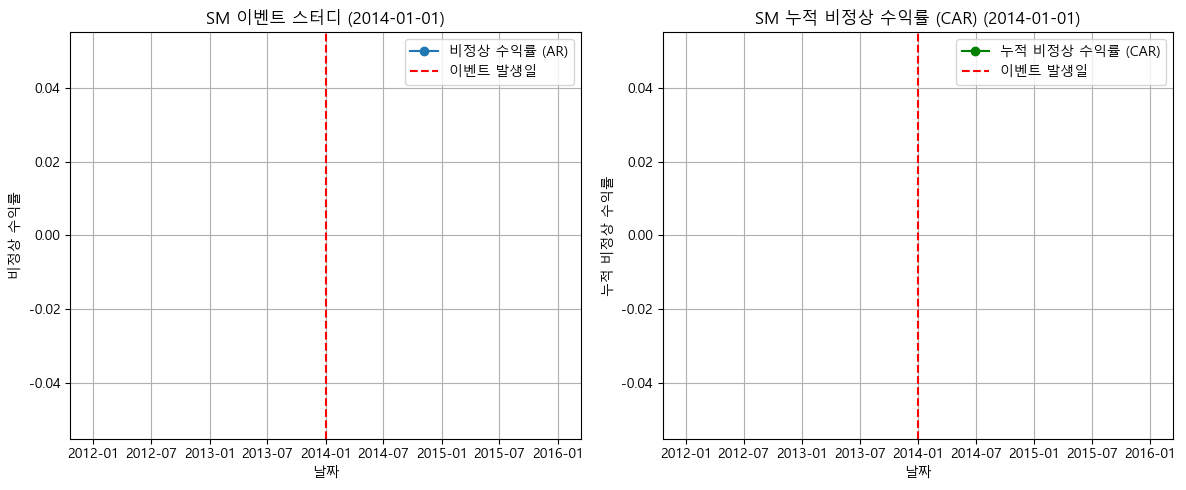

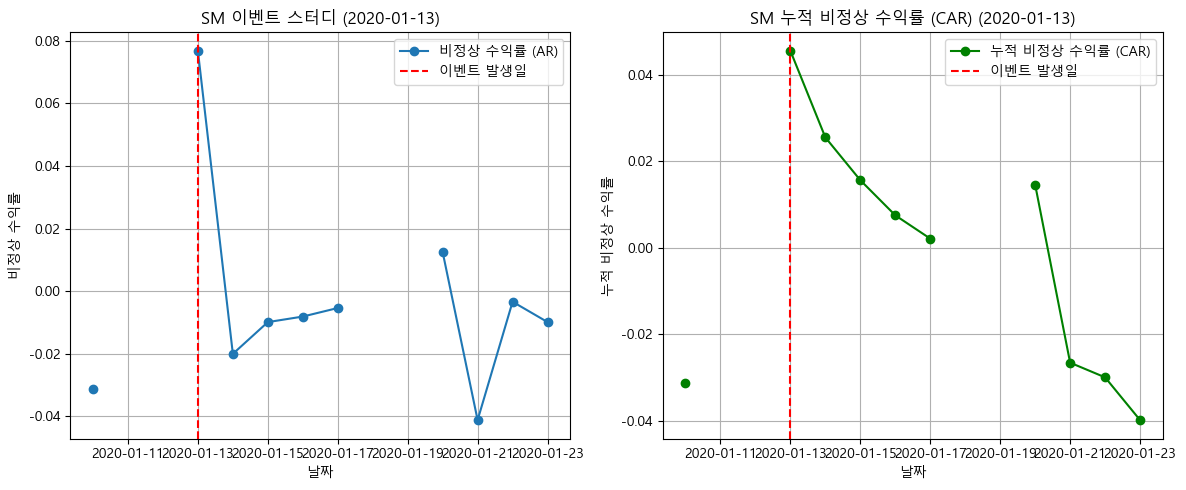

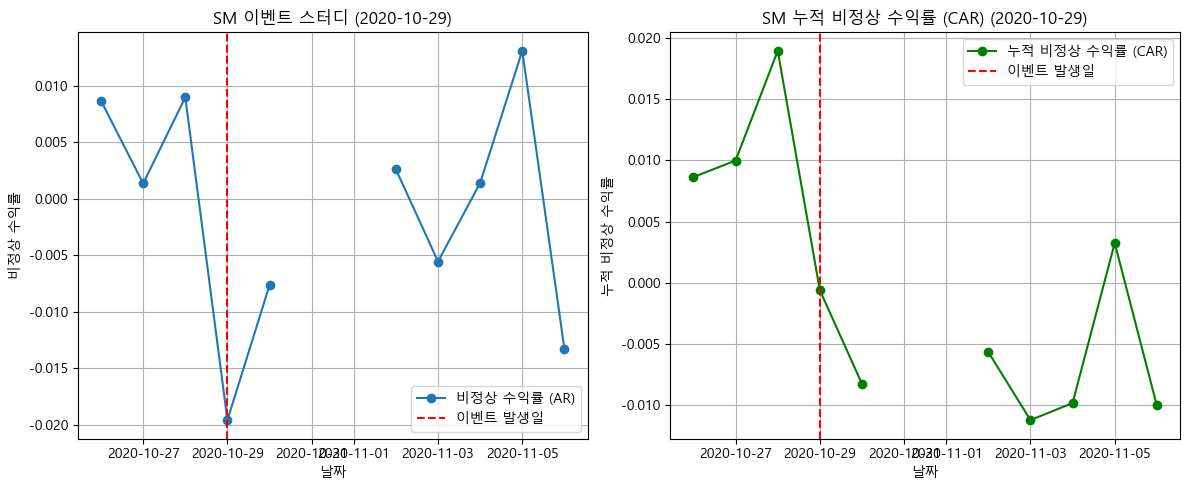

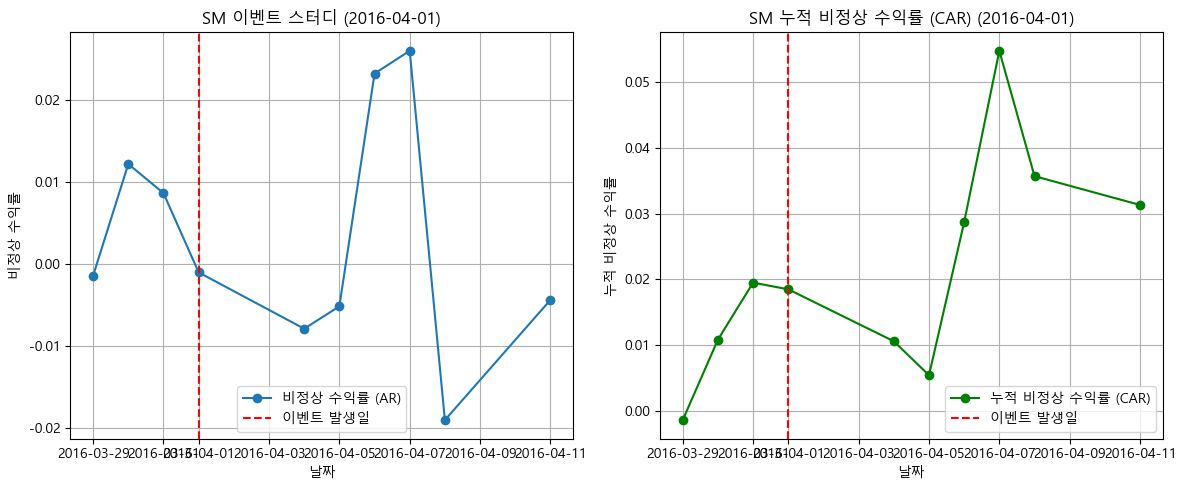

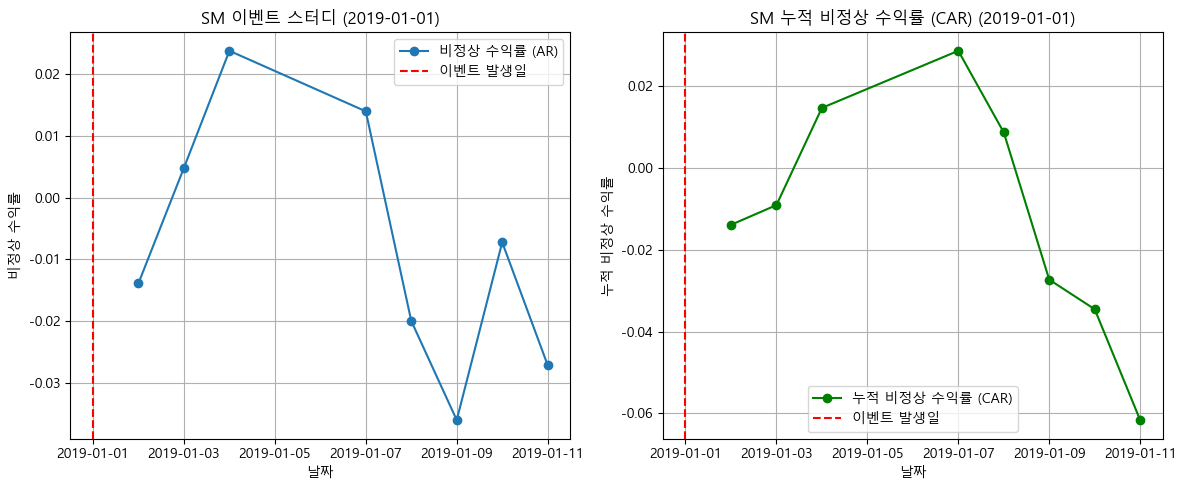

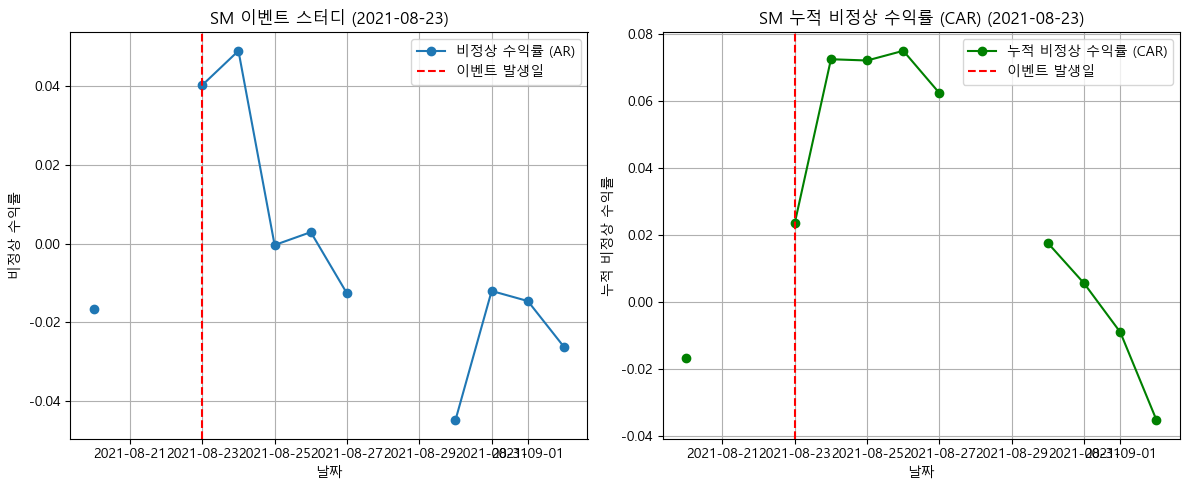

In [45]:
for ticker in ["SM"]:
    df = dataframes[ticker]
    for event_date in adjusted_events:
        plot_event_study(df, market_df, event_date, ticker)


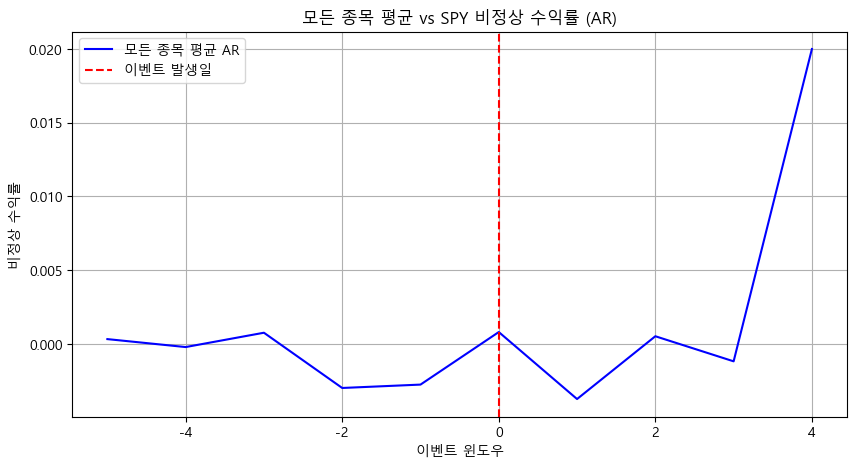

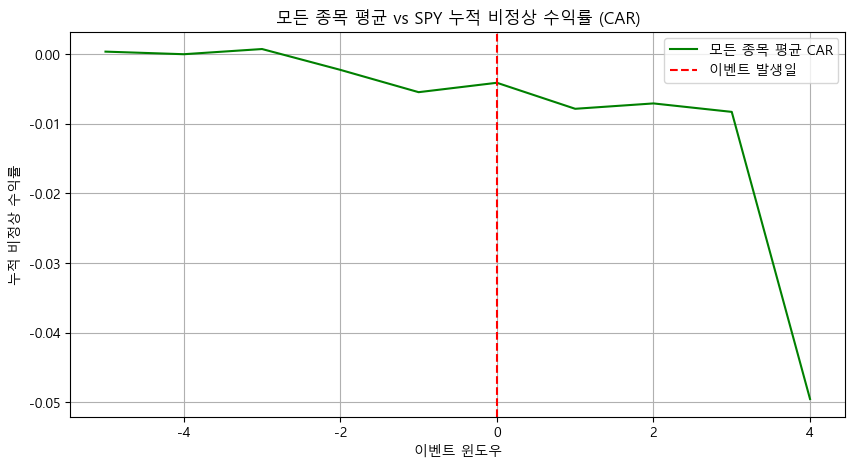

In [39]:
def plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events):
    """ SPY(시장수익률)와 모든 종목 평균 AR, CAR 그래프 출력 (x_range 길이 문제 해결 + CAR 추가) """
    set_korean_font()  # 한글 폰트 적용

    all_ar = pd.DataFrame()
    all_car = pd.DataFrame()

    x_range = None  # x축 범위를 고정하기 위한 변수 선언

    for ticker, df in dataframes.items():
        if ticker == "SPY":
            continue

        for event_date in adjusted_events:
            ar, car = calculate_abnormal_return(df, market_df, event_date)

            # x_range 설정 (처음 한 번만)
            if x_range is None:
                x_range = np.arange(-len(ar) // 2, len(ar) // 2 + 1)

            # 길이 맞추기: x_range와 ar의 길이가 다르면 조정
            min_length = min(len(x_range), len(ar))
            x_range = x_range[:min_length]
            ar = ar.iloc[:min_length]
            car = car.iloc[:min_length]

            ar.index = x_range  # 모든 종목에 동일한 x_range 적용
            car.index = x_range

            all_ar = pd.concat([all_ar, ar], axis=1)
            all_car = pd.concat([all_car, car], axis=1)

    # 평균 AR, CAR 계산
    mean_ar = all_ar.mean(axis=1)
    mean_car = all_car.mean(axis=1)

    # 📌 비정상 수익률 (AR) 그래프
    plt.figure(figsize=(10, 5))
    plt.plot(mean_ar.index, mean_ar, label="모든 종목 평균 AR", linestyle="-", color="blue")
    plt.axvline(0, color="red", linestyle="--", label="이벤트 발생일")

    plt.title("모든 종목 평균 vs SPY 비정상 수익률 (AR)")
    plt.xlabel("이벤트 윈도우")
    plt.ylabel("비정상 수익률")
    plt.legend()
    plt.grid()
    plt.show()

    # 📌 누적 비정상 수익률 (CAR) 그래프 추가
    plt.figure(figsize=(10, 5))
    plt.plot(mean_car.index, mean_car, label="모든 종목 평균 CAR", linestyle="-", color="green")
    plt.axvline(0, color="red", linestyle="--", label="이벤트 발생일")

    plt.title("모든 종목 평균 vs SPY 누적 비정상 수익률 (CAR)")
    plt.xlabel("이벤트 윈도우")
    plt.ylabel("누적 비정상 수익률")
    plt.legend()
    plt.grid()
    plt.show()

plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events)


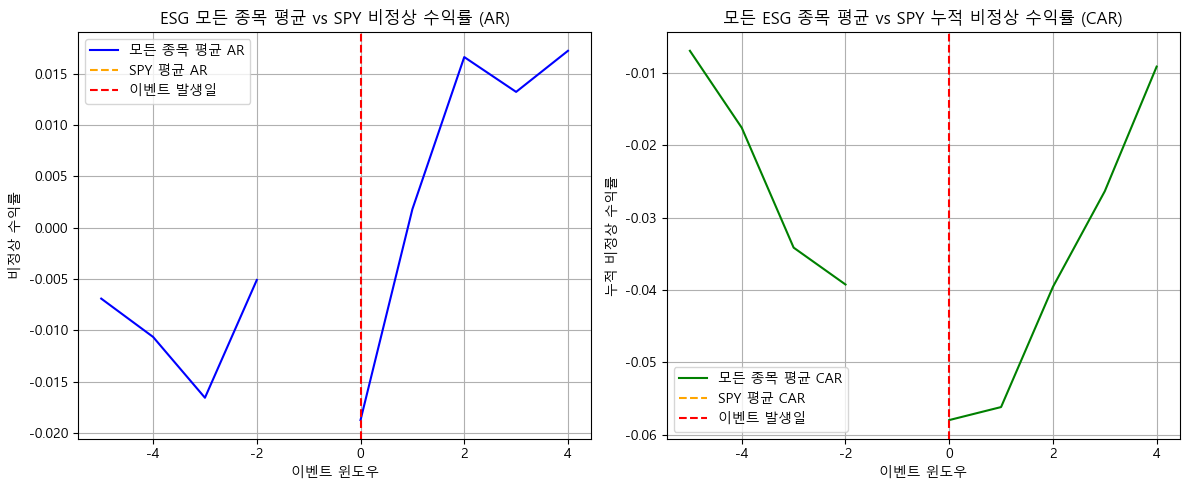

In [37]:
def plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events):
    """ SPY(시장수익률)와 모든 종목 평균 AR, CAR 그래프 출력 (SPY 추가 + 한 행 출력) """
    set_korean_font()  # 한글 폰트 적용

    all_ar = pd.DataFrame()
    all_car = pd.DataFrame()

    x_range = None  # x축 범위를 고정하기 위한 변수 선언

    for ticker, df in dataframes.items():
        if ticker == "코스닥":
            continue

        for event_date in adjusted_events:
            ar, car = calculate_abnormal_return(df, market_df, event_date)

            if x_range is None:
                x_range = np.arange(-len(ar) // 2, len(ar) // 2 + 1)

            # 길이 맞추기: x_range와 ar의 길이가 다르면 조정
            min_length = min(len(x_range), len(ar))
            x_range = x_range[:min_length]
            ar = ar.iloc[:min_length]
            car = car.iloc[:min_length]

            ar.index = x_range  # 모든 종목에 동일한 x_range 적용
            car.index = x_range

            all_ar = pd.concat([all_ar, ar], axis=1)
            all_car = pd.concat([all_car, car], axis=1)

    # 평균 AR, CAR 계산
    mean_ar = all_ar.mean(axis=1)
    mean_car = all_car.mean(axis=1)

    # 📌 SPY(시장수익률) AR, CAR 계산
    spy_ar_list = []
    spy_car_list = []

    for event_date in adjusted_events:
        spy_ar, spy_car = calculate_abnormal_return(dataframes["코스닥"], market_df, event_date)

        min_length = min(len(x_range), len(spy_ar))
        spy_ar = spy_ar.iloc[:min_length]
        spy_car = spy_car.iloc[:min_length]
        
        spy_ar.index = x_range
        spy_car.index = x_range

        spy_ar_list.append(spy_ar)
        spy_car_list.append(spy_car)

    spy_ar_mean = pd.concat(spy_ar_list, axis=1).mean(axis=1)
    spy_car_mean = pd.concat(spy_car_list, axis=1).mean(axis=1)

    # 📌 한 행(1x2)으로 AR & CAR 그래프 출력
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 비정상 수익률 (AR) 그래프
    axes[0].plot(mean_ar.index, mean_ar, label="모든 종목 평균 AR", linestyle="-", color="blue")
    axes[0].plot(spy_ar_mean.index, spy_ar_mean, label="SPY 평균 AR", linestyle="--", color="orange")
    axes[0].axvline(0, color="red", linestyle="--", label="이벤트 발생일")
    axes[0].set_title("ESG 모든 종목 평균 vs SPY 비정상 수익률 (AR)")
    axes[0].set_xlabel("이벤트 윈도우")
    axes[0].set_ylabel("비정상 수익률")
    axes[0].legend()
    axes[0].grid()

    # 누적 비정상 수익률 (CAR) 그래프
    axes[1].plot(mean_car.index, mean_car, label="모든 종목 평균 CAR", linestyle="-", color="green")
    axes[1].plot(spy_car_mean.index, spy_car_mean, label="SPY 평균 CAR", linestyle="--", color="orange")
    axes[1].axvline(0, color="red", linestyle="--", label="이벤트 발생일")
    axes[1].set_title("모든 ESG 종목 평균 vs SPY 누적 비정상 수익률 (CAR)")
    axes[1].set_xlabel("이벤트 윈도우")
    axes[1].set_ylabel("누적 비정상 수익률")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

# 실행
plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events)


In [32]:
def plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events, selected_tickers):
    """ 선택한 종목들의 평균 AR, CAR 그래프 출력 """
    set_korean_font()  # 한글 폰트 적용

    all_ar = pd.DataFrame()
    all_car = pd.DataFrame()

    x_range = None  # x축 범위를 고정하기 위한 변수 선언

    for ticker in selected_tickers:  # 선택한 종목만 사용
        if ticker not in dataframes:  # 데이터프레임에 없는 종목이면 건너뛰기
            print(f"⚠️ {ticker} 데이터가 없습니다. 제외하고 실행합니다.")
            continue

        df = dataframes[ticker]

        for event_date in adjusted_events:
            ar, car = calculate_abnormal_return(df, market_df, event_date)

            if x_range is None:
                x_range = np.arange(-len(ar) // 2, len(ar) // 2 + 1)

            # 길이 맞추기: x_range와 ar의 길이가 다르면 조정
            min_length = min(len(x_range), len(ar))
            x_range = x_range[:min_length]
            ar = ar.iloc[:min_length]
            car = car.iloc[:min_length]

            ar.index = x_range  # 모든 종목에 동일한 x_range 적용
            car.index = x_range

            all_ar = pd.concat([all_ar, ar], axis=1)
            all_car = pd.concat([all_car, car], axis=1)

    if all_ar.empty or all_car.empty:
        print("🚨 선택한 종목에서 유효한 데이터를 찾을 수 없습니다. 확인해주세요.")
        return

    # 평균 AR, CAR 계산
    mean_ar = all_ar.mean(axis=1)
    mean_car = all_car.mean(axis=1)

    # 📌 비정상 수익률 (AR) 그래프
    plt.figure(figsize=(10, 5))
    plt.plot(mean_ar.index, mean_ar, label="선택한 종목 평균 AR", linestyle="-", color="blue")
    plt.axvline(0, color="red", linestyle="--", label="이벤트 발생일")

    plt.title("선택한 종목 평균 vs SPY 비정상 수익률 (AR)")
    plt.xlabel("이벤트 윈도우")
    plt.ylabel("비정상 수익률")
    plt.legend()
    plt.grid()
    plt.show()

    # 📌 누적 비정상 수익률 (CAR) 그래프 추가
    plt.figure(figsize=(10, 5))
    plt.plot(mean_car.index, mean_car, label="선택한 종목 평균 CAR", linestyle="-", color="green")
    plt.axvline(0, color="red", linestyle="--", label="이벤트 발생일")

    plt.title("선택한 종목 평균 vs SPY 누적 비정상 수익률 (CAR)")
    plt.xlabel("이벤트 윈도우")
    plt.ylabel("누적 비정상 수익률")
    plt.legend()
    plt.grid()
    plt.show()


In [38]:
selected_tickers = ["RUN", "ENPH", "FSLR", "NEE"]  # 원하는 종목 선택
plot_highlighted_event_study_fix3(dataframes, market_df, adjusted_events, selected_tickers)


TypeError: plot_highlighted_event_study_fix3() takes 3 positional arguments but 4 were given